In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point, Polygon

import folium
from folium import Map
from folium.map import Layer, FeatureGroup,LayerControl,Marker
from folium.plugins import MarkerCluster,FeatureGroupSubGroup,Fullscreen

# Data Preparation

In [123]:
df = pd.read_csv(r'.\data\West_Nile_Virus_by_County.csv').reset_index()

df.drop(['id'], axis=1, inplace=True)

print(df.shape)
df.head()

(1395, 5)


,index,Year,Week_Reported,County,Positive_Cases
0,0,2006,35,Alameda,1
1,1,2006,33,Butte,4
2,2,2006,34,Butte,1
3,3,2006,35,Butte,10
4,4,2006,36,Butte,2


In [124]:
df.nunique()

index             1395
Year                10
Week_Reported       31
County              46
Positive_Cases      30
dtype: int64

In [125]:
df_coord = pd.read_csv(r'C:\Users\rmartinez4\Downloads\us-county-boundaries.csv', sep=';')
df_coord.head()

,Geo Point,Geo Shape,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,STUSAB,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,STATE_NAME,COUNTYFP NOZERO
0,"40.1763796295,-98.0471849897","{""type"": ""Polygon"", ""coordinates"": [[[-98.273667, 40.089399], [-98.273667, 40.089411], [-98.2736...",31,129,835886,31129,Nuckolls,Nuckolls County,NE,6,H1,G4020,NaN,NaN,NaN,A,1489645188,1718484,40.176492,-98.046842,Nebraska,129
1,"40.7715207081,-84.1057794323","{""type"": ""Polygon"", ""coordinates"": [[[-84.397189, 40.786584], [-84.397198, 40.787598], [-84.3971...",39,3,1074015,39003,Allen,Allen County,OH,6,H1,G4020,338.0,30620.0,NaN,A,1042479889,11259523,40.771627,-84.106103,Ohio,3
2,"41.9103521337,-81.250939242","{""type"": ""Polygon"", ""coordinates"": [[[-81.488643, 41.631522], [-81.488691, 41.635076], [-81.4902...",39,85,1074055,39085,Lake,Lake County,OH,6,H1,G4020,184.0,17460.0,NaN,A,593807218,1942301625,41.924116,-81.392643,Ohio,85
3,"37.5023005833,-94.3471107747","{""type"": ""Polygon"", ""coordinates"": [[[-94.617088, 37.477776], [-94.617083, 37.478637], [-94.6170...",29,11,758460,29011,Barton,Barton County,MO,6,H1,G4020,NaN,NaN,NaN,A,1533351029,12152201,37.500799,-94.344089,Missouri,11
4,"45.151770859,-86.0384960523","{""type"": ""Polygon"", ""coordinates"": [[[-85.561745, 44.952258], [-85.562092, 44.950788], [-85.5626...",26,89,1622987,26089,Leelanau,Leelanau County,MI,6,H1,G4020,NaN,45900.0,NaN,A,899241895,5659105307,45.146182,-86.051574,Michigan,89


In [126]:
df_coord = df_coord[df_coord['STATE_NAME']=='California']

In [127]:
df_coord.nunique()

Geo Point          58
Geo Shape          58
STATEFP             1
COUNTYFP           58
COUNTYNS           58
GEOID              58
NAME               58
NAMELSAD           58
STUSAB              1
LSAD                1
CLASSFP             2
MTFCC               1
CSAFP               5
CBSAFP             34
METDIVFP            5
FUNCSTAT            2
ALAND              58
AWATER             58
INTPTLAT           58
INTPTLON           58
STATE_NAME          1
COUNTYFP NOZERO    58
dtype: int64

In [128]:
df_coord = df_coord[['Geo Point', 'NAMELSAD']]
df_coord = df_coord.to_csv(r'.\data\us-county-boundaries.csv', index=False)
df_coord = pd.read_csv(r'.\data\us-county-boundaries.csv').reset_index()
print(df_coord.shape)
df_coord.head()

(58, 3)


,index,Geo Point,NAMELSAD
0,0,"36.0753604529,-119.815502709",Kings County
1,1,"36.6057058971,-121.074995529",San Benito County
2,2,"36.7581801263,-119.649322632",Fresno County
3,3,"40.0046824769,-120.838597596",Plumas County
4,4,"36.5111268089,-117.410789686",Inyo County


In [129]:
import py_stringmatching as sm
import py_stringsimjoin as ssj

ws = sm.WhitespaceTokenizer(return_set=True)

output_pairs = ssj.jaccard_join(df, df_coord, 'index', 'index', 'County', 'NAMELSAD', ws, 0.4, 
                                l_out_attrs=['County'], r_out_attrs=['NAMELSAD'])


c:\users\rmartinez4\anaconda3\envs\geo_env\lib\site-packages\py_stringsimjoin\utils\validation.py:30: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if attr_type != pd.np.object:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [130]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
output_pairs.head()

,_id,l_index,r_index,l_County,r_NAMELSAD,_sim_score
0,0,50,0,Kings,Kings County,0.5
1,1,200,0,Kings,Kings County,0.5
2,2,201,0,Kings,Kings County,0.5
3,3,202,0,Kings,Kings County,0.5
4,4,203,0,Kings,Kings County,0.5


<AxesSubplot:ylabel='Frequency'>

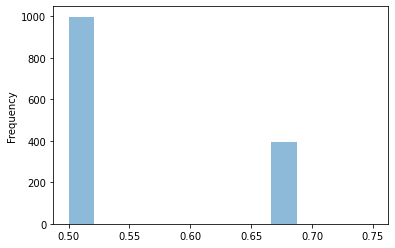

In [131]:
output_pairs['_sim_score'].plot.hist(bins=12, alpha=0.5)

In [141]:
df_match = output_pairs[['l_County', 'r_NAMELSAD', '_sim_score']]
df_match.drop_duplicates(inplace=True)

print(df_match.shape)
df_match.head()

(46, 3)


<ipython-input-141-92e6772cc916>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_match.drop_duplicates(inplace=True)


,l_County,r_NAMELSAD,_sim_score
0,Kings,Kings County,0.500000
19,Fresno,Fresno County,0.500000
103,Contra Costa,Contra Costa County,0.666667
137,Sutter,Sutter County,0.500000
164,Stanislaus,Stanislaus County,0.500000


In [139]:
df_final = df.merge(
                    df_match, left_on='County', right_on='l_County'
                    ).merge(
                            df_coord, left_on='r_NAMELSAD', right_on='NAMELSAD', how='left'
                            )

In [143]:
print(df_final.shape)
df_final.head()

(1395, 11)


,index_x,Year,Week_Reported,County,Positive_Cases,l_County,r_NAMELSAD,_sim_score,index_y,Geo Point,NAMELSAD
0,0,2006,35,Alameda,1,Alameda,Alameda County,0.5,50,"37.6504930265,-121.917998966",Alameda County
1,300,2008,32,Alameda,1,Alameda,Alameda County,0.5,50,"37.6504930265,-121.917998966",Alameda County
2,512,2010,43,Alameda,1,Alameda,Alameda County,0.5,50,"37.6504930265,-121.917998966",Alameda County
3,673,2012,42,Alameda,1,Alameda,Alameda County,0.5,50,"37.6504930265,-121.917998966",Alameda County
4,674,2012,43,Alameda,1,Alameda,Alameda County,0.5,50,"37.6504930265,-121.917998966",Alameda County


In [142]:
cols = ['Year', 'Week_Reported', 'County', 'Positive_Cases', 'Geo Point']
df_final[cols].to_csv(r'.\data\final_df.csv', index=False)

# Data Visualization

In [ ]:
df_final = pd.read_csv(r'.\data\final_df.csv')